# 1. Data

Every problem starts with data....

Obviously there are a multitude of data sets out there. Thus, this tutorial will make use of two data sets: the stylized "International Airline Passengers" data set as well as a self generated data set of stock prices download from Yahoo! Finance.

In [23]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# basic functionalities
import re
import os
import sys
import datetime
import itertools
import math 


# data transforamtion and manipulation
import pandas as pd
import pandas_datareader.data as web
import numpy as np
# prevent crazy long pandas prints
pd.options.display.max_columns = 16
pd.options.display.max_rows = 16
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)


# remove warnings
import warnings
warnings.filterwarnings('ignore')


# plotting and plot stying
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn')
#sns.set_style("whitegrid", {'axes.grid' : False})
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"


# statistical modeling libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
#from arch import arch_model


# deep learning
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model 


# jupyter wdgets
from ipywidgets import interactive, widgets, RadioButtons, ToggleButtons, Select, FloatSlider, FloatProgress
from IPython.display import set_matplotlib_formats, Image

Using TensorFlow backend.


## 1.1 Working with Data (Structures)

The <code>pandas</code> module allows to introduce data management to data. Using the <code>read_csv</code> method the data is strung into a <code>DataFrame</code> object which allows to directly access the data and providing the means for data analysis and transformation. A dataframe is a collection of <code>Series</code> objects.

A much better formatting of the data can be established if additional arguments are specified when importing the data set, for example:
<ul>
<li><strong>header</strong>: include the first row as the header for the <code>DataFrame</code> object</li>
<li><strong>index_col</strong>: set the index column of the DataFrame to the first column of the data set ('month')</li>
<li><strong>parse_dates</strong>: automatically parse dates which will index the DataFrame</li>
<li><strong>sep</strong>: specify the symbol which seperates the values and strings in the data set - in this case it is semi-colon</li>
</ul>

In [4]:
# load passenger data set and safe to DataFrame
pas = pd.read_csv('./data/passengers.csv', header=0, index_col=0, parse_dates=True, sep=';')

In [5]:
# print the first 5 rows of the DataFrame
pas.head()

,n_passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [6]:
# print the type of an object
type(pas)

pandas.core.frame.DataFrame

In [7]:
# print the data type of all columns except for the index column
pas.dtypes

n_passengers    int64
dtype: object

In [8]:
# print summary statistics
pas.describe()

,n_passengers
count,144.00000
mean,280.29861
std,119.96632
min,104.00000
25%,180.00000
50%,265.50000
75%,360.50000
max,622.00000


Indexes are important in the domain of pandas data transformations and the applicability of prebuilt analytics methods from other libraries.

In [9]:
# list the index of the DataFrame
pas.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='month', length=144, freq=None)

In [10]:
# save the n_passenger column to a new variable, this becomes a Series object
y = pas['n_passengers']

# or
y = pas.n_passengers

In [11]:
# print first 5 rows
y.head()

month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: n_passengers, dtype: int64

In [12]:
# print type of the ts object
type(y)

pandas.core.series.Series

In [13]:
# select all entries from the year '1950'
y['1950']

month
1950-01-01    115
1950-02-01    126
1950-03-01    141
1950-04-01    135
1950-05-01    125
1950-06-01    149
1950-07-01    170
1950-08-01    170
1950-09-01    158
1950-10-01    133
1950-11-01    114
1950-12-01    140
Name: n_passengers, dtype: int64

## 1.2 Download Historical Data

This is a sample workflow of how to retrieve data directly from the web using the <code>pandas_datareader</code> module to access <strong>stock price data</strong> from the Yahoo! Finance or Google Finance APIs. Yahoo! Finance is up to now the most popular service, and thus it will also be used here.

In [14]:
# define arguments
tickers = ['AAPL', 'AMZN', 'FB', 'GOOG', 'NFLX', '^GSPC']
provider = 'yahoo'
start = datetime.datetime(2012, 5, 18)
end = datetime.date(2017, 8, 22)

In [16]:
# ask Yahoo! Finance for data
panel = web.DataReader(tickers, provider, start, end)

Without further specification, this command returns a <code>Panel</code> object. A panel can be thought of as a collection of <code>DateFrame</code> object. 

Additional data is also provided by this service, such as <strong>corporate actions</strong> like stock split or dividend payments

In [ ]:
# ask Yahoo! Finance for data
corporate_actions = web.DataReader(tickers, 'yahoo-actions', start, end)

In [ ]:
corporate_actions

In [ ]:
# show corporate actions axes
corporate_actions.axes

In [ ]:
corporate_actions.loc['Stock Splits', '2012' ,'AAPL']

To get the adjusted prices only, that is, prices that are corrected for dividend payments such that there are no jumps or breaks in the stock time series. Using the <code>loc</code> selector a column element across all included dataframes can be selected

In [17]:
# get adjusted closing prices from all data series
# this reduces the Panel to a DataFrame
adj_close = panel.loc['Adj Close']

# get all weekdays between 18.05.2012 and 22.08.2017
all_weekdays = pd.date_range(start=start, end=end, freq='B')

# adjust the DataFrame index to be only the weekdays
adj_close = adj_close.reindex(all_weekdays)

# after reindexing we have to amend for missing values
adj_close = adj_close.fillna(method='ffill')

In [ ]:
# have a look at what we have created
adj_close.head()

In [ ]:
type(adj_close)

## 1.3 Build a stock price data set

The <code>Panel</code> object we created earlier contains much more that then we actually need for this notebook. Thus, we can use a more elegant way to can exaclty the data that we want

In [18]:
# ask Yahoo! Finance for data and save to DataFrame
data = web.DataReader(tickers, 'yahoo', start, end)['Adj Close']

# save data to a .csv
data.to_csv('./data/stock_data.csv', sep=';')

# show the data
data.head()

,AAPL,AMZN,FB,GOOG,NFLX,^GSPC
Date,,,,,,
2012-05-17,68.13225,218.36000,nan,309.51193,10.28143,1304.85999
2012-05-18,68.16567,213.85001,38.23000,298.26010,9.99429,1295.21997
2012-05-21,72.13699,218.11000,34.03000,305.07080,10.24857,1315.98999
2012-05-22,71.58306,215.33000,31.00000,298.45880,9.67286,1316.63000
2012-05-23,73.32967,217.28000,32.00000,302.76083,10.27286,1318.85999


In [19]:
# import data from a .csv
data = pd.read_csv('./data/stock_data.csv', header=0, sep=';', parse_dates=True, index_col=0)

# rearrange data to only show week days
all_weekdays = pd.date_range(start=start, end=end, freq='B')
data = data.reindex(all_weekdays)

# after reindexing we have to amend for missing values
data = data.fillna(method='ffill')
data.head()

,AAPL,AMZN,FB,GOOG,NFLX,^GSPC
2012-05-18,68.16567,213.85001,38.23000,298.26010,9.99429,1295.21997
2012-05-21,72.13699,218.11000,34.03000,305.07080,10.24857,1315.98999
2012-05-22,71.58306,215.33000,31.00000,298.45880,9.67286,1316.63000
2012-05-23,73.32967,217.28000,32.00000,302.76083,10.27286,1318.85999
2012-05-24,72.65621,215.24000,33.03000,299.87958,10.03857,1320.68005


How many working days are there in a year?

In [20]:
# the actual length of one year of working days 365 - 2 * 52
len(pd.date_range(start=datetime.datetime(2012, 5, 18), end=datetime.datetime(2013, 5, 18), freq='B'))

261

## 1.4 Data visualization

Main tools for plotting in this Notebook are the libraries <code>matplotlib</code>, which contains a lot of the functionalities available in MathLab without the interface, and <code>seaborn</code>.

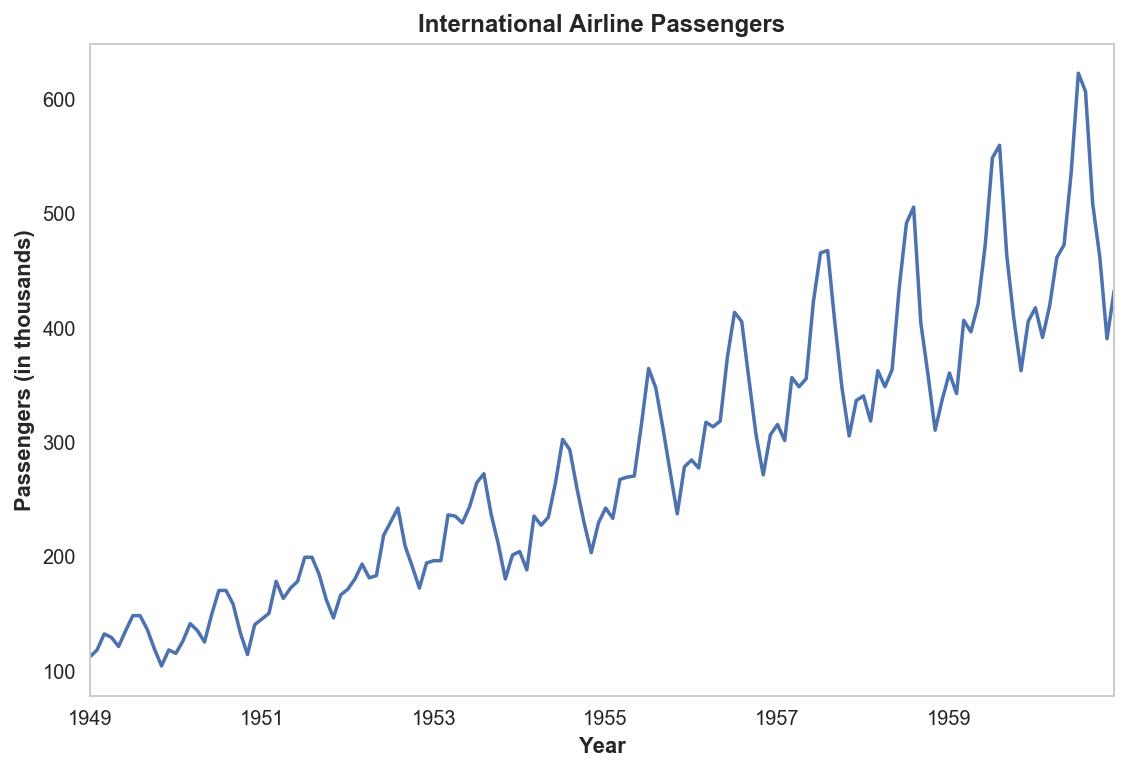

In [21]:
# initialize figure and axis
fig, ax = plt.subplots();

# plot resampled series
pas['n_passengers'].plot(ax=ax);

# style the plot
ax.set_title('International Airline Passengers');
ax.set_ylabel('Passengers (in thousands)');
ax.set_xlabel('Year');
ax.xaxis.set_ticks_position('bottom');
fig.tight_layout();

# show the plot
plt.show()

There appears to be some kind trend component included in this time series. 

By using the <code>resample</code> method on the <code>DataFrame</code> object (the time series) with  argument <code>'AS'</code> a new time series is constructed. The series as it is resampled is offest at the beginning of each year. By summing the resampled values we can see a steady increase of total passengers over the years.

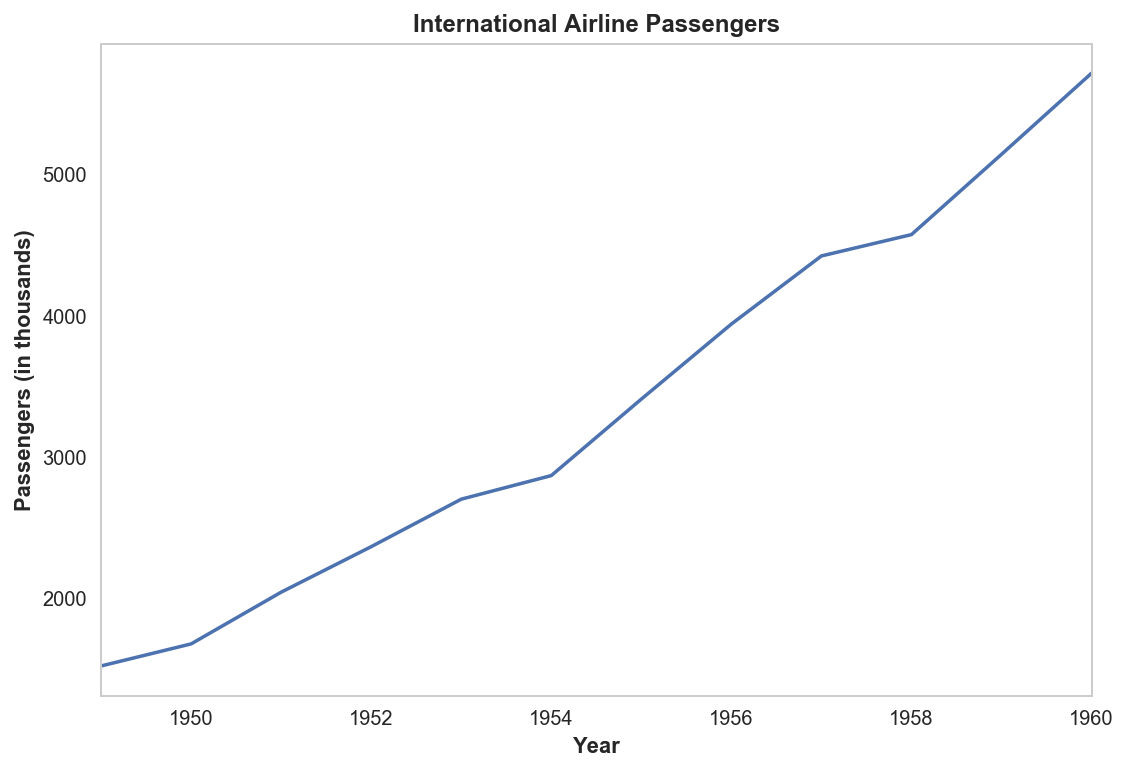

In [22]:
# initialize figure and axis
fig, ax = plt.subplots();

# plot resampled series
pas['n_passengers'].resample('AS').sum().plot(ax=ax)

# style the plot
ax.set_title('International Airline Passengers', fontweight='bold');
ax.set_ylabel('Passengers (in thousands)');
ax.set_xlabel('Year');
ax.xaxis.set_ticks_position('bottom');
fig.tight_layout();

# show the plot
plt.show()

## 1.5 Exercise

Import the earlier created stock prices data set and save it in a formatted fashion to a variable called <code>stock</code>. You may want to use import arguments. It can be found in the <code>./data/raw_data.csv</code> in your corresponding path. Have a look at the top rows and print the summary statistics. 

Asign the Apple stock time series to a <code>Series</code> object named <code>ts</code> and plot it

Open the data folder and have a look at the other data sets. Your are free to explore these as well. Is there anything peculiar about the <code>temp_ger.csv</code> data set?